# Imports

In [1]:
from PIL import Image
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt
import time

# Load data

In [2]:
n_sections = 5
section_names = ['9.2_S1', # Ndnf-Npy-Egln3
                 '9.13_S1', # Ndnf-Npy-Egln3
                 '9.13_S2', # Ndnf-Npy-Egln3
                 '9.2_S5', # Vip-Tac2-Npy2r 
                 '9.2_S6' #Vip-Tac2-Npy2r
                ]
section_folders = ['Z:\HCR\9.2_FISH', 'Z:\HCR\HCR_9.13', 'Z:\HCR\HCR_9.13', 'Z:\HCR\9.2_FISH', 'Z:\HCR\9.2_FISH']
section_files = ['S1_data.pkl', 'S1_data.pkl', 'S2_data.pkl', 'S5_data.pkl', 'S6_data.pkl']
image_folders = ['Z:\HCR\9.2_FISH\S1_16bit\S1_dapi_546_488_647',
                 'Z:\HCR\HCR_9.13\S1_546_647_dapi_514_z-stack_tiles_2019_09_16__22_04_08-Rotate 2D-01',
                 'Z:\HCR\HCR_9.13\S2_546_647_dapi_514_z-stack_tiles_2019_09_17__00_55_58',
                 'Z:\HCR\9.2_FISH\S5_dapi_546_488_647',
                 'Z:\HCR\9.2_FISH\S6_488_647_dapi_546_z-stack_tiles_2019_09_14__00_22_08']
image_files = ['S1_dapi_546_488_647_s2z',
              'S1_546_647_dapi_514_z-stack_tiles_2019_09_16__22_04_08-Rotate 2D-01_z',
              'S2_546_647_dapi_514_z-stack_tiles_2019_09_17__00_55_58_z',
              'S5_dapi_546_488_647_z',
              'S6_488_647_dapi_546_z-stack_tiles_2019_09_14__00_22_08_z']
first_plane = [1, 1, 1, 16, 1]
last_plane = [29, 19, 19, 33, 30]
seg_channel = [0, 0, 0, 3, 1]
gene1 = ['Npy', 'Npy', 'Npy', 'Tac2', 'Tac2']
gene2 = ['Egln3', 'Egln3', 'Egln3', 'Npy2r', 'Npy2r']
gene1_channel = [2, 3, 3, 1, 0]
gene2_channel = [3, 1, 1, 2, 3]
plane_nos = {s: range(first_plane[s], last_plane[s]) for s in range(n_sections)}



In [3]:
cell_masks = {}
n_cells = np.zeros(n_sections).astype(int)
for section in range(n_sections):
    with open('{0}/{1}'.format(section_folders[section], section_files[section]), 'rb') as f:
        cell_masks[section] = pkl.load(f)
        n_cells[section] = len(cell_masks[section].keys())

In [4]:
len(cell_masks[3].keys())

200

In [5]:
indices = list(cell_masks[3].keys())
if not np.max(indices) == len(indices):
    print('Re-numbering cells to be consecutive')
    cell_data_temp = {}
    for i in range(len(indices)):
        cell_data_temp[i + 1] = cell_masks[3][indices[i]]
        cell_data_temp[i + 1]['cell_id'] = i + 1
    cell_masks[3] = cell_data_temp 

# Calculate intensities

In [6]:
gene1_intensity = {s: np.zeros(n_cells[s]) for s in range(n_sections)}
gene2_intensity = {s: np.zeros(n_cells[s]) for s in range(n_sections)}

In [10]:
start = time.time()
for s in range(0, n_sections):
    print('Section {0}'.format(section_names[s]))
    try:
        # Load data if previously calculated
        with open('{0}/{1}_{2}_intensities'.format(section_folders[s], section_names[s], gene1[s]), 'rb') as f:
                gene1_intensity[s] = pkl.load(f)
        with open('{0}/{1}_{2}_intensities'.format(section_folders[s], section_names[s], gene2[s]), 'rb') as f:
            gene2_intensity[s] = pkl.load(f)
    except:
        print('No data found, intensities need to be calculated')
    
        img = Image.open('{0}\{1}{2}c{3}_ORG.tif'.format(image_folders[s], image_files[s], str(plane_nos[s][0]).zfill(2), 
                                                         seg_channel[s] + 1))
        h = img.height
        w = img.width
        print('Size of each image in pixels: {0} X {1}'.format(h, w))
        print('Creating coordinate array')
        xv = range(w)
        yv = range(h)
        coord_array = np.array(np.meshgrid(xv, yv))

        points = np.zeros([h*w, 2])
        p = 0
        for i in range(h):
            for j in range(w):
                points[p, 1] = coord_array[0, i, j]
                points[p, 0] = coord_array[1, i, j]
                p += 1

        print('Loading images for gene 1')
        n = len(plane_nos[s])
        im_array = np.zeros([n, h, w])
        for i in range(n):
            p = plane_nos[s][i]
            img = Image.open('{0}\{1}{2}c{3}_ORG.tif'.format(image_folders[s], image_files[s], str(p).zfill(2), 
                                                             gene1_channel[s] + 1))
            try:
                im_array[i, :, :] = np.array(img)
            except:
                print('Plane {0} could not be loaded'.format(p))
                print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
                im_array = np.delete(im_array, i, axis = 0)
                plane_nos.remove(p)
                i -= 1
                n = len(plane_nos)
                continue

        print('Loading images for gene 2')
        im_array2 = np.zeros([n, h, w])
        for i in range(n):
            p = plane_nos[s][i]
            img = Image.open('{0}\{1}{2}c{3}_ORG.tif'.format(image_folders[s], image_files[s], str(p).zfill(2), 
                                                             gene2_channel[s] + 1))
            try:
                im_array2[i, :, :] = np.array(img)
            except:
                print('Plane {0} could not be loaded'.format(p))
                print('{0}\{1}{2}c{3}_ORG.tif'.format(image_folders[s], image_files[s], str(p).zfill(2), 
                                                             gene2_channel[s] + 1))
                print('Size of plane {0} in pixels: {1} X {2}'.format(p, img.height, img.width))
                im_array = np.delete(im_array, i, axis = 0)
                plane_nos.remove(p)
                i -= 1
                n = len(plane_nos)
                continue

        print('Calculating intensities')
        for cell in range(n_cells[s]):

            if np.mod(cell, 50) == 0:
                print('Cell {0}'.format(cell))
                print('Elapsed time = {0}'.format(time.time() - start))
            cell_no = cell + 1
            cell_dict = cell_masks[s][cell_no]
            masks = cell_dict['masks']
            z_planes = cell_dict['z_planes']

            intensity_gene1 = np.zeros(cell_dict['no_planes'])
            intensity_gene2 = np.zeros(cell_dict['no_planes'])

            i = 0
            for plane in z_planes:

                vertices = masks[plane]
                path = mpltpath.Path(vertices)
                mask = path.contains_points(points)
                mask = np.reshape(mask, [h, w])

                intensity_gene1[i] = np.mean(im_array[plane, mask])
                intensity_gene2[i] = np.mean(im_array2[plane, mask])
                i += 1

            gene1_intensity[s][cell] = np.mean(intensity_gene1)
            gene2_intensity[s][cell] = np.mean(intensity_gene2)

        with open('{0}/{1}_{2}_intensities'.format(section_folders[s], section_names[s], gene1[s]), 'wb') as f:
            pkl.dump(gene1_intensity[s], f)

        with open('{0}/{1}_{2}_intensities'.format(section_folders[s], section_names[s], gene2[s]), 'wb') as f:
            pkl.dump(gene2_intensity[s], f)


Section 9.2_S1
Section 9.13_S1
Section 9.13_S2
Section 9.2_S5
Section 9.2_S6


In [ ]:
s = 1
with open('{0}/{1}_{2}_intensities'.format(section_folders[s], section_names[s], gene1[s]), 'wb') as f:
        pkl.dump(gene1_intensity[s], f)

with open('{0}/{1}_{2}_intensities'.format(section_folders[s], section_names[s], gene2[s]), 'wb') as f:
    pkl.dump(gene2_intensity[s], f)

# Scatter plots

In [12]:
gene1_thresh = [0.29309731117890503, 0.29309731117890503, 0.29309731117890503, 0.34034559717672858, 0.34034559717672858]
gene2_thresh = [0.25769369405765008, 0.25769369405765008, 0.25769369405765008, 0.21459618544027878, 0.21459618544027878]

In [49]:
%matplotlib qt

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in 

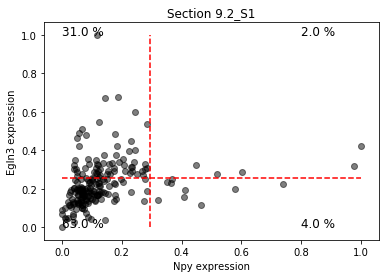

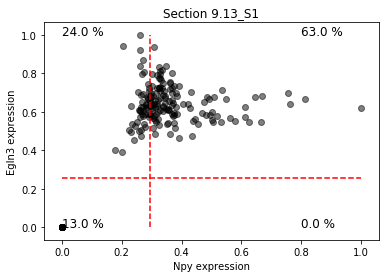

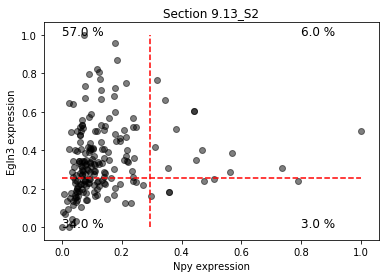

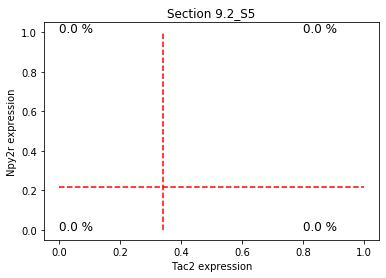

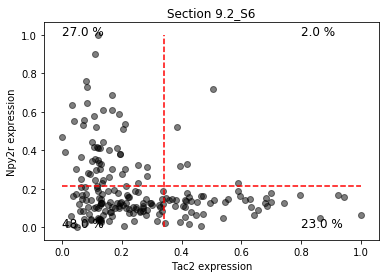

In [13]:
for s in range(n_sections):
    gene1_level = gene1_intensity[s] 
    gene1_level = gene1_level - np.min(gene1_level)
    gene2_level = gene2_intensity[s]
    gene2_level = gene2_level - np.min(gene2_level)
    plt.figure()
    plt.scatter(gene1_level/np.max(gene1_level), gene2_level/np.max(gene2_level), alpha = 0.5, color = 'k')
    plt.xlabel('{0} expression'.format(gene1[s]))
    plt.ylabel('{0} expression'.format(gene2[s]))
    t1 = gene1_thresh[s]
    t2 = gene2_thresh[s]
    plt.plot(np.ones(2)*gene1_thresh[s], np.array(range(0, 2)), '--', color = 'r')
    plt.plot(np.array(range(0, 2)), np.ones(2)*gene2_thresh[s], '--',  color = 'r')
    
    q1 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < gene1_thresh[s], 
                        gene2_level/np.max(gene2_level) < gene2_thresh[s]))
    plt.text(0, 0, '{0} %'.format(np.round(q1/n_cells[s]*100, decimals = 0)), fontsize = 12)
    
    q2 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < gene1_thresh[s], 
                        gene2_level/np.max(gene2_level) > gene2_thresh[s]))
    plt.text(0, 1, '{0} %'.format(np.round(q2/n_cells[s]*100, decimals = 0)), fontsize = 12)
    
    q3 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > gene1_thresh[s], 
                        gene2_level/np.max(gene2_level) < gene2_thresh[s]))
    plt.text(0.8, 0, '{0} %'.format(np.round(q3/n_cells[s]*100, decimals = 0)), fontsize = 12)
    
    q4 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > gene1_thresh[s], 
                        gene2_level/np.max(gene2_level) > gene2_thresh[s]))
    plt.text(0.8, 1, '{0} %'.format(np.round(q4/n_cells[s]*100, decimals = 0)), fontsize = 12)
    
    plt.title('Section {0}'.format(section_names[s]))
    

In [75]:
gene1_intensity[1] = gene1_intensity[1][:169]

In [76]:
gene2_intensity[1] = gene2_intensity[1][:169]

In [69]:
203 + 195 + 200

598

In [66]:
plt.close('all')

In [64]:
gene2_intensity[3] = gene2_intensity[3][:-1]

In [65]:
gene2_intensity[3].shape

(199,)

In [63]:
gene1_intensity[3].shape

(199,)

In [50]:
np.array(range(0, 2))

array([0, 1])

In [51]:
np.ones(2)

array([ 1.,  1.])

In [ ]:
gene1_thes